In [2]:
import warnings
warnings.filterwarnings('ignore')
import os
import torch
import clip
from scripts.clip_wrapper import ClipWrapper
from scripts.plot import visualize_vandt_heatmap
from scripts.methods import vision_heatmap_iba, text_heatmap_iba
from transformers import CLIPProcessor, CLIPModel, CLIPTokenizerFast
from PIL import Image, ImageOps
os.environ["TOKENIZERS_PARALLELISM"] = "false"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [3]:
import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset
import torchvision.transforms as T


class NIHSingleLabelBBoxDataset(Dataset):
    def __init__(self, csv_path, images_dir, transform=None):
        self.df = pd.read_csv(csv_path)
        self.images_dir = images_dir
        self.transform = transform

        # Get sorted list of unique labels
        self.label_list = sorted(self.df['Finding Label'].unique())
        self.label_to_idx = {label: i for i, label in enumerate(self.label_list)}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_name = row['Image Index']
        label = row['Finding Label']
        bbox = [row['Bbox [x'], row['y'], row['w'], row['h]']]

        # Load image
        img_path = os.path.join(self.images_dir, img_name)
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        label_idx = self.label_to_idx[label]
        # return image, label_idx, bbox
        return image, label, bbox, img_name

In [4]:
def plot(model, image, text, vbeta=0.1, vvar=1, vlayer=9, tbeta=0.1, tvar=1, tlayer=9, bb=None, ):
    # Preprocess image
    image = Image.open(image).convert('RGB')
    image_feat = processor(images=image, return_tensors="pt")['pixel_values'].to(device) # 3*224*224
    # Tokenize text
    text_ids = torch.tensor([tokenizer.encode(text, add_special_tokens=True)]).to(device)
    text_words = tokenizer.convert_ids_to_tokens(text_ids[0].tolist())
    # Train information bottleneck on image
    print("Training M2IB on the image...")
    vmap = vision_heatmap_iba(text_ids, image_feat, model, vlayer, vbeta, vvar)
    # Train information bottleneck on text
    print("Training M2IB on the text...")
    tmap = text_heatmap_iba(text_ids, image_feat, model, tlayer, tbeta, tvar)
    image_under = processor(images=image, return_tensors="pt", do_normalize=False)['pixel_values'][0].permute(1,2,0) # no normalization
    if bb:
        scaled_bb = []
        for x, y, w, h in bb:
            hr, vr = image_under.shape[0]/image.size[0], image_under.shape[1]/image.size[1]
            scaled_bb.append((x*hr, y*vr, w*hr, h*vr))
        bb = scaled_bb
    visualize_vandt_heatmap(tmap, vmap, text_words, image_under, bb=bb)
    return vmap

# Conceptual Captions

Conceptual Caption provides a large amount of images and their raw descriptions collected from the web. The examples below are from its validation split.

# MS-CXR

The MS-CXR dataset is a radiology dataset that provides 1162 image–sentence pairs of bounding boxes and corresponding phrases. Please download the dataset from https://physionet.org/content/ms-cxr/0.1/. We provide two examples below for illustration purpose.
- To be able to run the following code, you need to first download checkpoint finetuned on xray data from https://github.com/rajpurkarlab/CXR-RePaiR.

In [8]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
tokenizer = CLIPTokenizerFast.from_pretrained("openai/clip-vit-base-patch32")


med_model, med_preprocess= clip.load("ViT-B/32", device=device)
med_model.load_state_dict(torch.load("data/clip-imp-pretrained_128_6_after_4.pt", map_location=device))
med_model1 = ClipWrapper(med_model)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


(1024, 1024)
<PIL.Image.Image image mode=RGB size=1024x1024 at 0x1C42833D0>
[131.796610169492, 706.476843882415, 221.28813559322, 123.661016949153]
Atelectasis
imageSize <class 'PIL.Image.Image'>
Training M2IB on the image...


Training Bottleneck: 100%|██████████| 10/10 [00:26<00:00,  2.63s/it]


Training M2IB on the text...


Training Bottleneck: 100%|██████████| 10/10 [00:18<00:00,  1.83s/it]

<class 'numpy.ndarray'>


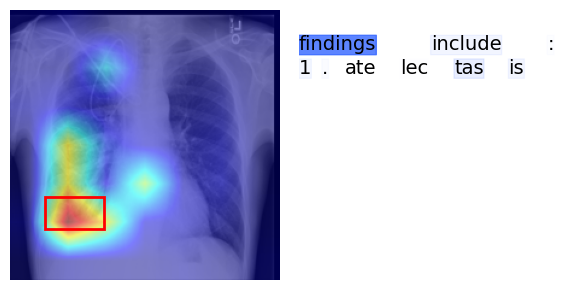

In [54]:
dataset = NIHSingleLabelBBoxDataset(
    csv_path='data/BBox_List_2017.csv',
    images_dir='data/main_images',
    transform=None
)

image_dir = 'data/main_images'
image, label, bbox, img_name = dataset.__getitem__(16)
print(image.size)
print(image)
print(bbox)
print(label)
print("imageSize",type(image))
import os
full_path = os.path.join(image_dir, img_name)
img = full_path
text = 'findings include: 1. ' + label
bb = [(bbox[0],bbox[1],bbox[2],bbox[3])]
vmap = plot(med_model1, img, text,vbeta = 1, vvar=1, vlayer=9, tbeta=1, tvar=1, tlayer=7, bb=bb)
# vmap = plot(med_model, img, "a chest X-ray",vbeta = 1, vvar=1, vlayer=9, tbeta=1, tvar=1, tlayer=7, bb=bb)
print(type(vmap))







(1024, 1024)
Training M2IB on the image...


Training Bottleneck: 100%|██████████| 10/10 [01:28<00:00,  8.83s/it]


Training M2IB on the text...


Training Bottleneck: 100%|██████████| 10/10 [01:21<00:00,  8.19s/it]


(1024, 1024)


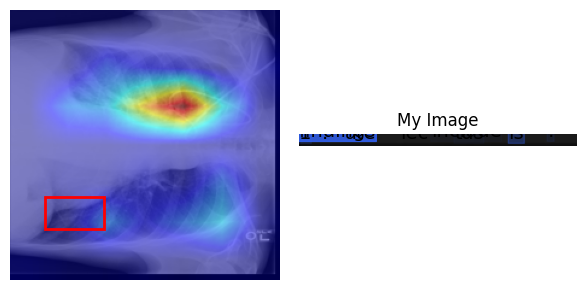

In [76]:
from PIL import Image, ImageOps
from PIL import Image
import cv2
import numpy as np





def plot_transformation(model, image, text, vbeta=0.1, vvar=1, vlayer=9, tbeta=0.1, tvar=1, tlayer=9, bb=None, ):
    # Preprocess image
    # image = Image.open(image).convert('RGB')
    image_feat = processor(images=image, return_tensors="pt")['pixel_values'].to(device) # 3*224*224
    # Tokenize text
    text_ids = torch.tensor([tokenizer.encode(text, add_special_tokens=True)]).to(device)
    text_words = tokenizer.convert_ids_to_tokens(text_ids[0].tolist())
    # Train information bottleneck on image
    print("Training M2IB on the image...")
    vmap = vision_heatmap_iba(text_ids, image_feat, model, vlayer, vbeta, vvar)
    # Train information bottleneck on text
    print("Training M2IB on the text...")
    tmap = text_heatmap_iba(text_ids, image_feat, model, tlayer, tbeta, tvar)
    image_under = processor(images=image, return_tensors="pt", do_normalize=False)['pixel_values'][0].permute(1,2,0) # no normalization
    if bb:
        scaled_bb = []
        for x, y, w, h in bb:
            hr, vr = image_under.shape[0]/image.size[0], image_under.shape[1]/image.size[1]
            scaled_bb.append((x*hr, y*vr, w*hr, h*vr))
        bb = scaled_bb
    visualize_vandt_heatmap(tmap, vmap, text_words, image_under, bb=bb)
    return vmap



image = Image.open(img).convert('RGB')

rotated = image.rotate(10, expand=True)

print(rotated.size)
  # degrees counterclockwise
# rotated = rotated.rotate(20)
vmap = plot_transformation(med_model1, rotated , text,vbeta = 1, vvar=1, vlayer=9, tbeta=1, tvar=1, tlayer=7, bb=bb)

print(rotated.size)

plt.imshow(rotated)
plt.axis('off')  # optional: hide axis
plt.title("My Image")  # optional: add title
plt.show()




In [90]:
# Image size
tile_size = 25
tiles_x, tiles_y = 4, 4
height = tiles_y * tile_size
width = tiles_x * tile_size

# Create empty RGB image (uint8 type)
img_np = np.zeros((height, width, 3), dtype=np.uint8)

# Define 3 colors
colors = [
    [255, 0, 0],   # Red
    [0, 255, 0],   # Green
    [0, 0, 255],   # Blue
]

# Fill with repeating tiles
for i in range(tiles_y):
    for j in range(tiles_x):
        color = colors[(i + j) % len(colors)]  # change pattern logic if needed
        y_start = i * tile_size
        y_end = y_start + tile_size
        x_start = j * tile_size
        x_end = x_start + tile_size
        img_np[y_start:y_end, x_start:x_end] = color

# Convert to PIL image
img_pil = Image.fromarray(img_np)
rotated = img_pil.rotate(10, expand=True)

np.array(rotated).shape

# plt.imshow(img_pil)
# plt.imshow(rotated)

# Show image








(116, 116, 3)

In [15]:


def rescale_bbox_to_224(bbox, orig_width, orig_height):
    x, y, w, h = bbox
    x_new = x * (224 / orig_width)
    y_new = y * (224 / orig_height)
    w_new = w * (224 / orig_width)
    h_new = h * (224 / orig_height)
    return [x_new, y_new, w_new, h_new]


def threshold_heatmap(vmap, threshold=0.5):
    vmap_norm = (vmap - vmap.min()) / (vmap.max() - vmap.min())
    return (vmap_norm > threshold).float()


def bbox_to_mask(bbox):
    mask = torch.zeros((224, 224))
    x1, x2 = int(bbox[0]), int(bbox[0] + bbox[2])
    y1, y2 = int(bbox[1]), int(bbox[1] + bbox[3])
    mask[y1:y2, x1:x2] = 1
    return mask


new_bbox = rescale_bbox_to_224(bbox, 1024, 1024)
bbox_mask = bbox_to_mask(new_bbox)
v_map = torch.from_numpy(vmap)
vmap_mask = threshold_heatmap(v_map)


def compute_iou(mask1, mask2):
    intersection = (mask1 * mask2).sum()
    union = ((mask1 + mask2) > 0).float().sum()
    return (intersection / union).item()


def precision(pred_mask, gt_mask):
    tp = (pred_mask * gt_mask).sum()
    predicted_positives = pred_mask.sum()
    return (tp / predicted_positives).item() if predicted_positives > 0 else 0.0


def recall(pred_mask, gt_mask):
    tp = (pred_mask * gt_mask).sum()
    actual_positives = gt_mask.sum()
    return (tp / actual_positives).item() if actual_positives > 0 else 0.0


iou=compute_iou(vmap_mask,bbox_mask)
persision = precision(vmap_mask,bbox_mask)
recall = recall(vmap_mask,bbox_mask)

print("iou",iou)
print("persision",persision)
print("recall", recall)


iou 0.33079180121421814
persision 0.35085538029670715
recall 0.8526077270507812


In [74]:
import torch.nn.functional as F


# med_model = ClipWrapper(med_model)

def get_clip_similarity(model, processor, image_tensor, text):


    print("before procc",image_tensor.size)

    # inputs = processor(images=image_tensor, text=[text], return_tensors="pt").to(device)

    image_tensor = processor(image_tensor).unsqueeze(0).to(device)
    text_tokens = clip.tokenize([text]).to(device)



    with torch.no_grad():
        image_features = model.encode_image(image_tensor)
        text_features = model.encode_text(text_tokens)

    # Normalize (L2)
    image_features = F.normalize(image_features, dim=-1)
    text_features = F.normalize(text_features, dim=-1)

    # Compute cosine similarity
    similarity = (image_features @ text_features.T).item()



    return similarity


get_clip_similarity(med_model, med_preprocess, image, text )

before procc (1024, 1024)


0.27737075090408325

<class 'torch.Tensor'>
<class 'numpy.ndarray'>
size of image (1024, 1024, 3)
type of image <class 'PIL.Image.Image'>
RGB
size of mask (1024, 1024)


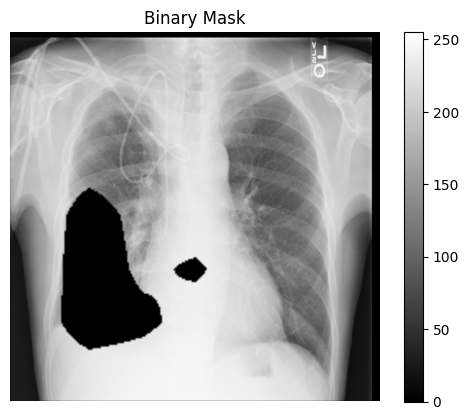

before procc (1024, 1024)


0.29153257608413696

In [47]:
### delete important part of image


# def(image, vmap)

import torch
import numpy as np
import cv2

print(type(vmap_mask))
vmap_mask_numpy = vmap_mask.detach().cpu().numpy()


print(type(vmap_mask_numpy))

print("size of image",np.array(image).shape)

print("type of image",type(image))

print(image.mode)

resized_heatmap = cv2.resize(vmap_mask_numpy, (1024, 1024), interpolation=cv2.INTER_LINEAR)
resized_heatmap = (resized_heatmap - resized_heatmap.min()) / (resized_heatmap.max() - resized_heatmap.min())


print("size of mask",np.array(resized_heatmap).shape)


mask_rgb = np.stack([resized_heatmap]*3, axis=-1) 


# print("size of mask",np.array(mask_rgb).shape)


output = np.array(image) * (1 - mask_rgb)

output = Image.fromarray(output.astype(np.uint8))



import matplotlib.pyplot as plt
# mask_np = resized_heatmap.numpy()
# # Plot
plt.imshow(output, cmap='gray')  # or use cmap='Reds' or 'hot'
plt.title("Binary Mask")
plt.axis('off')
plt.colorbar()
plt.show()


get_clip_similarity(med_model, med_preprocess, output, text)


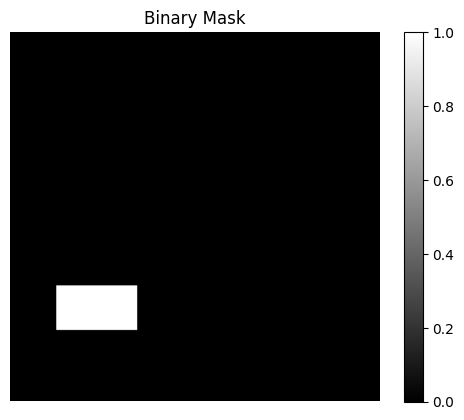

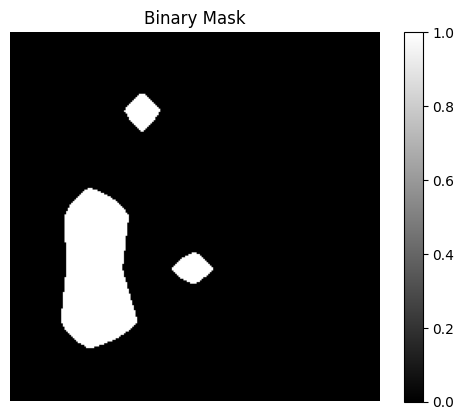

In [231]:
import matplotlib.pyplot as plt

# mask = bbox_to_mask(bbox)

import matplotlib.pyplot as plt
mask1 = mask.numpy()
# Plot
plt.imshow(mask1, cmap='gray')  # or use cmap='Reds' or 'hot'
plt.title("Binary Mask")
plt.axis('off')
plt.colorbar()
plt.show()

mask_np = vmap_mask.numpy()
# Plot
plt.imshow(mask_np, cmap='gray')  # or use cmap='Reds' or 'hot'
plt.title("Binary Mask")
plt.axis('off')
plt.colorbar()
plt.show()


